In [47]:
import pandas as pd

# Paths
dx_csv = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
labels_csv = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"

# Load CSVs
dx_df = pd.read_csv(dx_csv)
labels_df = pd.read_csv(labels_csv)

# Ensure SNOMED codes are strings (important for matching)
dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)

# Extract label codes from ECG CSV (skip non-label columns)
non_label_cols = {"path", "age", "gender", "fs"}
label_codes = [col for col in labels_df.columns if col not in non_label_cols]

# Find shared SNOMED codes
shared_codes = set(label_codes).intersection(set(dx_df["SNOMEDCTCode"]))

# Filter diagnosis names for shared codes
shared_labels = (
    dx_df[dx_df["SNOMEDCTCode"].isin(shared_codes)]
    [["SNOMEDCTCode", "Dx", "Abbreviation"]]
    .sort_values("Dx")
)

# Show results
print(f"Number of shared labels: {len(shared_labels)}\n")
print(shared_labels.to_string(index=False))


Number of shared labels: 17

SNOMEDCTCode                                   Dx Abbreviation
   270492004                  1st degree av block         IAVB
   164889003                  atrial fibrillation           AF
   164890007                       atrial flutter          AFL
   713426002 incomplete right bundle branch block        IRBBB
   445118002       left anterior fascicular block        LAnFB
    39732003                  left axis deviation          LAD
   164909002             left bundle branch block         LBBB
   251146004                     low qrs voltages        LQRSV
   284470004         premature atrial contraction          PAC
    47665007                 right axis deviation          RAD
    59118001            right bundle branch block         RBBB
   427393009                     sinus arrhythmia           SA
   426177001                    sinus bradycardia           SB
   426783006                         sinus rhythm          NSR
   427084000              

In [48]:
TARGET_LABELS = [
    "1st degree av block",
    "atrial fibrillation",
    "atrial flutter",
    "incomplete right bundle branch block",
    "left anterior fascicular block",
    "left axis deviation",
    "left bundle branch block",
    "low qrs voltages",
    "premature atrial contraction",
    "right axis deviation",
    "right bundle branch block",
    "sinus arrhythmia",
    "sinus bradycardia",
    "sinus rhythm",
    "sinus tachycardia",
    "t wave abnormal",
    "t wave inversion",
]


In [50]:
def build_label_mapper(ecg_labels, target_labels):
    """
    Returns:
        dict[target_label] = list of ecg_label_indices
    """
    mapper = {}

    ecg_labels_lower = [l.lower() for l in ecg_labels]

    for tgt in target_labels:
        tgt_l = tgt.lower()
        matched_idxs = []

        for i, ecg_l in enumerate(ecg_labels_lower):
            # conservative matching rules
            if tgt_l in ecg_l or ecg_l in tgt_l:
                matched_idxs.append(i)

        mapper[tgt] = matched_idxs

    return mapper

def print_label_mapping(ecg_labels, label_mapper):
    print("=" * 100)
    print("ECGFOUNDER LABEL  →  TARGET (SNOMED) LABEL MAPPING")
    print("=" * 100)

    for target_label, ecg_indices in label_mapper.items():
        print(f"\nTARGET LABEL: {target_label}")
        print("-" * 100)

        if len(ecg_indices) == 0:
            print("  ❌ No matching ECGFounder labels")
            continue

        for idx in ecg_indices:
            print(f"  ✓ ECGFounder[{idx:3d}]: {ecg_labels[idx]}")



In [51]:
mapper = build_label_mapper(TARGET_LABELS, ECGFOUNDER_LABELS)

# Full analysis

In [64]:
"""
=================================================================================
SETUP AND DEBUG SCRIPT
=================================================================================

Use this script to:
1. Verify your data structure matches the expectations
2. Create tasks.txt if you don't have it
3. Debug label mapping before running full evaluation
"""

import pandas as pd
import numpy as np


def verify_data_structure():
    """Verify your CSV files have the correct structure"""
    
    print("\n" + "="*100)
    print("VERIFYING DATA STRUCTURE")
    print("="*100)
    
    # Paths - MODIFY THESE
    dx_csv_path = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
    test_csv_path = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"
    
    try:
        dx_df = pd.read_csv(dx_csv_path)
        test_df = pd.read_csv(test_csv_path)
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        return False
    
    print(f"\n1. Diagnosis CSV ({dx_csv_path}):")
    print(f"   Shape: {dx_df.shape}")
    print(f"   Columns: {list(dx_df.columns)}")
    print(f"\n   First few rows:")
    print(dx_df.head(3).to_string())
    
    print(f"\n2. Test Data CSV ({test_csv_path}):")
    print(f"   Shape: {test_df.shape}")
    print(f"   Columns (first 10): {list(test_df.columns[:10])}")
    print(f"   Total columns: {len(test_df.columns)}")
    
    # Non-label columns
    non_label_cols = {"path", "age", "gender", "fs"}
    label_cols = [col for col in test_df.columns if col not in non_label_cols]
    
    print(f"\n3. Label Columns (SNOMED codes):")
    print(f"   Total: {len(label_cols)}")
    print(f"   First 10: {label_cols[:10]}")
    
    # Create mapping
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    snomed_to_dx = dict(zip(dx_df["SNOMEDCTCode"], dx_df["Dx"]))
    
    print(f"\n4. SNOMED to Diagnosis Mapping:")
    for code in label_cols[:5]:
        dx_name = snomed_to_dx.get(code, "NOT FOUND")
        print(f"   {code} -> {dx_name}")
    
    # Check sample row
    print(f"\n5. Sample Row (test_df.iloc[0]):")
    sample_row = test_df.iloc[0]
    print(f"   path: {sample_row['path']}")
    print(f"   age: {sample_row['age']}")
    print(f"   gender: {sample_row['gender']}")
    print(f"   fs: {sample_row['fs']}")
    print(f"   Labels (first 5): {[(code, sample_row[code]) for code in label_cols[:5]]}")
    
    return True


def create_sample_tasks_txt(output_path="tasks.txt"):
    """
    Create a sample tasks.txt file with ECGFounder labels.
    
    NOTE: You should populate this with ACTUAL labels from your model's output.
    This is just a template based on the original code.
    """
    
    # These are the original labels from your code
    labels = [
        "ABNORMAL ECG",
        "NORMAL SINUS RHYTHM",
        "NORMAL ECG",
        "SINUS RHYTHM",
        "SINUS BRADYCARDIA",
        "ATRIAL FIBRILLATION",
        "SINUS TACHYCARDIA",
        "otherwise normal ecg",
        "LEFT AXIS DEVIATION",
        "PREMATURE VENTRICULAR COMPLEXES",
        "BORDERLINE ECG",
        "RIGHT BUNDLE BRANCH BLOCK",
        "SEPTAL INFARCT",
        "LEFT ATRIAL ENLARGEMENT",
        "NONSPECIFIC T WAVE ABNORMALITY",
        "LOW VOLTAGE QRS",
        "PREMATURE ATRIAL COMPLEXES",
        "ANTERIOR INFARCT",
        "INCOMPLETE RIGHT BUNDLE BRANCH BLOCK",
        "PREMATURE SUPRAVENTRICULAR COMPLEXES",
        "LEFT BUNDLE BRANCH BLOCK",
        "NONSPECIFIC T WAVE ABNORMALITY NOW EVIDENT IN",
        "NONSPECIFIC T WAVE ABNORMALITY NO LONGER EVIDENT IN",
        "T WAVE INVERSION NOW EVIDENT IN",
        "LATERAL INFARCT",
        "NONSPECIFIC ST ABNORMALITY",
        "LEFT VENTRICULAR HYPERTROPHY",
        "T WAVE INVERSION NO LONGER EVIDENT IN",
        "WITH RAPID VENTRICULAR RESPONSE",
        "QT HAS SHORTENED",
        "QT HAS LENGTHENED",
        "FUSION COMPLEXES",
        "ATRIAL FLUTTER",
        "MARKED SINUS BRADYCARDIA",
        "WITH SINUS ARRHYTHMIA",
        "NONSPECIFIC ST AND T WAVE ABNORMALITY",
        "LEFT ANTERIOR FASCICULAR BLOCK",
        "RIGHT AXIS DEVIATION",
        "ECTOPIC ATRIAL RHYTHM",
        "UNDETERMINED RHYTHM",
        "ANTEROSEPTAL INFARCT",
        "RIGHTWARD AXIS",
        "ST NOW DEPRESSED IN",
        "WITH SHORT PR",
        "WITH MARKED SINUS ARRHYTHMIA",
        "ST NO LONGER DEPRESSED IN",
        "INVERTED T WAVES HAVE REPLACED NONSPECIFIC T WAVE ABNORMALITY IN",
        "NON-SPECIFIC CHANGE IN ST SEGMENT IN",
        "NONSPECIFIC T WAVE ABNORMALITY HAS REPLACED INVERTED T WAVES IN",
        "JUNCTIONAL RHYTHM",
        "ELECTRONIC ATRIAL PACEMAKER",
        "ABERRANT CONDUCTION",
        "ELECTRONIC VENTRICULAR PACEMAKER",
        "T WAVE INVERSION LESS EVIDENT IN",
        "ANTEROLATERAL INFARCT",
        "WITH REPOLARIZATION ABNORMALITY",
        "RSR' OR QR PATTERN IN V1 SUGGESTS RIGHT VENTRICULAR CONDUCTION DELAY",
        "T WAVE INVERSION MORE EVIDENT IN",
        "WIDE QRS RHYTHM",
        "WITH PREMATURE VENTRICULAR OR ABERRANTLY CONDUCTED COMPLEXES",
        "RIGHT ATRIAL ENLARGEMENT",
        "INFERIOR INFARCT",
        "INCOMPLETE LEFT BUNDLE BRANCH BLOCK",
        "VOLTAGE CRITERIA FOR LEFT VENTRICULAR HYPERTROPHY",
        "OR DIGITALIS EFFECT",
        "BIFASCICULAR BLOCK",
        "ST NO LONGER ELEVATED IN",
        "WITH SLOW VENTRICULAR RESPONSE",
        "ST ELEVATION NOW PRESENT IN",
        "PREMATURE ECTOPIC COMPLEXES",
        "LEFT POSTERIOR FASCICULAR BLOCK",
        "T WAVE AMPLITUDE HAS DECREASED IN",
        "WITH A COMPETING JUNCTIONAL PACEMAKER",
        "RIGHT SUPERIOR AXIS DEVIATION",
        "BIATRIAL ENLARGEMENT",
        "VENTRICULAR-PACED RHYTHM",
        "ATRIAL-PACED RHYTHM",
        "T WAVE AMPLITUDE HAS INCREASED IN",
        "WITH QRS WIDENING",
        "WITH 1ST DEGREE AV BLOCK",
        "PROLONGED QT",
        "WITH PROLONGED AV CONDUCTION",
        "RIGHT VENTRICULAR HYPERTROPHY",
        "WITH QRS WIDENING AND REPOLARIZATION ABNORMALITY",
        "ATRIAL-SENSED VENTRICULAR-PACED RHYTHM",
        "AV SEQUENTIAL OR DUAL CHAMBER ELECTRONIC PACEMAKER",
        "PULMONARY DISEASE PATTERN",
        "ACUTE MI / STEMI",
        "INFERIOR-POSTERIOR INFARCT",
        "NONSPECIFIC INTRAVENTRICULAR CONDUCTION DELAY",
        "PREMATURE VENTRICULAR AND FUSION COMPLEXES",
        "IN A PATTERN OF BIGEMINY",
        "AV DUAL-PACED RHYTHM",
        "SUPRAVENTRICULAR TACHYCARDIA",
        "VENTRICULAR-PACED COMPLEXES",
        "WIDE QRS TACHYCARDIA",
        "RSR' PATTERN IN V1",
        "ST LESS DEPRESSED IN",
        "VENTRICULAR TACHYCARDIA",
        "EARLY REPOLARIZATION",
        "ST MORE DEPRESSED IN",
        "ANTEROLATERAL LEADS",
        "ELECTRONIC DEMAND PACING",
        "RBBB AND LEFT ANTERIOR FASCICULAR BLOCK",
        "LATERAL INJURY PATTERN",
        "BIVENTRICULAR PACEMAKER DETECTED",
        "SUSPECT UNSPECIFIED PACEMAKER FAILURE",
        "WOLFF-PARKINSON-WHITE",
        "WITH VENTRICULAR ESCAPE COMPLEXES",
        "INFERIOR INJURY PATTERN",
        "CONSIDER RIGHT VENTRICULAR INVOLVEMENT IN ACUTE INFERIOR INFARCT",
        "ST ELEVATION HAS REPLACED ST DEPRESSION IN",
        "NONSPECIFIC INTRAVENTRICULAR BLOCK",
        "MASKED BY FASCICULAR BLOCK",
        "PEDIATRIC ECG ANALYSIS",
        "BLOCKED",
        "WITH UNDETERMINED RHYTHM IRREGULARITY",
        "LEFTWARD AXIS",
        "WITH 2ND DEGREE SA BLOCK MOBITZ I",
        "ACUTE",
        "ABNORMAL LEFT AXIS DEVIATION",
        "WITH COMPLETE HEART BLOCK",
        "NO P-WAVES FOUND",
        "ST LESS ELEVATED IN",
        "WITH RETROGRADE CONDUCTION",
        "ST MORE ELEVATED IN",
        "JUNCTIONAL BRADYCARDIA",
        "WITH VARIABLE AV BLOCK",
        "ANTERIOR INJURY PATTERN",
        "WITH JUNCTIONAL ESCAPE COMPLEXES",
        "ACUTE MI",
        "ACUTE PERICARDITIS",
        "POSTERIOR INFARCT",
        "IDIOVENTRICULAR RHYTHM",
        "WITH 2ND DEGREE SA BLOCK MOBITZ II",
        "R IN AVL",
        "SINUS/ATRIAL CAPTURE",
        "AV DUAL-PACED COMPLEXES",
        "INFEROLATERAL INJURY PATTERN",
        "RBBB AND LEFT POSTERIOR FASCICULAR BLOCK",
        "ANTEROLATERAL INJURY PATTERN",
        "ATRIAL-PACED COMPLEXES",
        "WITH SINUS PAUSE",
        "BIVENTRICULAR HYPERTROPHY",
        "ABNORMAL RIGHT AXIS DEVIATION",
        "SUPRAVENTRICULAR COMPLEXES",
        "WITH 2ND DEGREE AV BLOCK MOBITZ I",
        "WITH 2:1 AV CONDUCTION",
        "WITH AV DISSOCIATION",
        "MULTIFOCAL ATRIAL TACHYCARDIA",
    ]
    
    # Write to file
    with open(output_path, 'w') as f:
        for label in labels:
            f.write(label + '\n')
    
    print(f"\n✓ Created tasks.txt with {len(labels)} labels at: {output_path}")
    print(f"  First 5 labels:")
    for label in labels[:5]:
        print(f"    - {label}")


def show_diagnosis_mapping():
    """Show the mapping between SNOMED codes and diagnosis names"""
    
    print("\n" + "="*100)
    print("DIAGNOSIS MAPPING (SNOMED -> Name)")
    print("="*100)
    
    dx_csv_path = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
    test_csv_path = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"
    
    try:
        dx_df = pd.read_csv(dx_csv_path)
        test_df = pd.read_csv(test_csv_path)
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
        return
    
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    
    non_label_cols = {"path", "age", "gender", "fs"}
    label_cols = [col for col in test_df.columns if col not in non_label_cols]
    
    print(f"\n{'SNOMED Code':<20} | {'Diagnosis Name':<50} | {'Abbreviation':<10}")
    print("-"*100)
    
    for code in label_cols:
        row = dx_df[dx_df["SNOMEDCTCode"] == code]
        if not row.empty:
            dx_name = row['Dx'].values[0]
            abbr = row['Abbreviation'].values[0]
            print(f"{code:<20} | {dx_name:<50} | {abbr:<10}")
        else:
            print(f"{code:<20} | {'NOT FOUND':<50} | {'':<10}")


# =============================================================================
# MAIN
# =============================================================================

if __name__ == "__main__":
    print("\n" + "="*100)
    print("SETUP AND DEBUG UTILITY")
    print("="*100)
    
    # Step 1: Verify data structure
    print("\nStep 1: Verifying data structure...")
    if verify_data_structure():
        print("\n✓ Data structure verified!")
    
    # Step 2: Show diagnosis mapping
    print("\nStep 2: Showing diagnosis mapping...")
    show_diagnosis_mapping()
    
    # Step 3: Create tasks.txt
    print("\nStep 3: Creating tasks.txt...")
    create_sample_tasks_txt("tasks.txt")
    
    print("\n" + "="*100)
    print("SETUP COMPLETE!")
    print("="*100)
    print("\nNext steps:")
    print("1. Verify that tasks.txt was created with your ECGFounder model's output labels")
    print("2. Update TASKS_TXT_PATH in zero_shot_evaluation_corrected.py")
    print("3. Run: python zero_shot_evaluation_corrected.py")
    print()


SETUP AND DEBUG UTILITY

Step 1: Verifying data structure...

VERIFYING DATA STRUCTURE

1. Diagnosis CSV (/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv):
   Shape: (30, 13)
   Columns: ['Dx', 'SNOMEDCTCode', 'Abbreviation', 'CPSC', 'CPSC_Extra', 'StPetersburg', 'PTB', 'PTB_XL', 'Georgia', 'Chapman_Shaoxing', 'Ningbo', 'Total', 'Notes']

   First few rows:
                    Dx  SNOMEDCTCode Abbreviation  CPSC  CPSC_Extra  StPetersburg  PTB  PTB_XL  Georgia  Chapman_Shaoxing  Ningbo  Total Notes
0  atrial fibrillation     164889003           AF  1221         153             2   15    1514      570              1780       0   5255   NaN
1       atrial flutter     164890007          AFL     0          54             0    1      73      186               445    7615   8374   NaN
2  bundle branch block       6374002          BBB     0           0             1   20       0      116                 0     385    522   NaN

2. Test Data CSV (/home/zoorab/project

In [69]:
"""
=================================================================================
ZERO-SHOT EVALUATION: CLEAN & STRICT 1-TO-1 MAPPING WITH CORRECT LABEL ORDER
=================================================================================

Key Features:
- Loads ECGFounder labels from tasks.txt
- Dynamically loads TARGET_LABELS from test_df column order (SNOMED codes)
- Proper 1-to-1 manual mapping (ONE source per target)
- Clinical accuracy (no "NORMAL", no "NO LONGER", no conflicting labels)
- Correct alignment with ground truth
=================================================================================
"""

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# LABEL LOADING (DYNAMIC)
# =============================================================================

def load_ecgfounder_labels(tasks_txt_path):
    """
    Load ECGFounder labels from tasks.txt file.
    Each line is one label.
    """
    with open(tasks_txt_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"✓ Loaded {len(labels)} ECGFounder labels from tasks.txt")
    return labels


def load_target_labels_from_data(test_df, dx_csv_path):
    """
    Load TARGET_LABELS from the test DataFrame and diagnosis CSV.
    This ensures the order matches the DataFrame column order.
    
    Parameters:
    -----------
    test_df : pd.DataFrame
        Test dataset with SNOMED code columns
    dx_csv_path : str
        Path to scored_diagnoses_2021.csv
    
    Returns:
    --------
    target_labels : list
        List of diagnosis names in the same order as test_df columns
    snomed_to_dx : dict
        Mapping from SNOMED code to diagnosis name
    """
    # Load diagnosis mappings
    dx_df = pd.read_csv(dx_csv_path)
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    
    # Create SNOMED to diagnosis mapping
    snomed_to_dx = dict(zip(dx_df["SNOMEDCTCode"], dx_df["Dx"]))
    
    # Non-label columns
    non_label_cols = {"path", "age", "gender", "fs"}
    
    # Extract label columns from test_df in their original order
    label_codes = [col for col in test_df.columns if col not in non_label_cols]
    
    # Convert to diagnosis names (preserving order from DataFrame)
    target_labels = [snomed_to_dx.get(code, f"Unknown_{code}") for code in label_codes]
    
    print(f"✓ Loaded {len(target_labels)} target labels from test DataFrame")
    print(f"  Label codes (SNOMED): {label_codes}")
    
    return target_labels, label_codes, snomed_to_dx


# =============================================================================
# STRICT 1-TO-1 MANUAL MAPPER
# =============================================================================

def build_strict_one_to_one_mapper(target_labels, ecgfounder_labels):
    """
    STRICT 1-TO-1 MAPPING: Each target gets EXACTLY ONE source ECGFounder label
    
    Clinical Rules Applied:
    1. No "NORMAL" labels (they mean absence of pathology)
    2. No "NO LONGER", "LESS EVIDENT" (means resolved/improving)
    3. No "MARKED" (different severity)
    4. No "WITH" prefixes where standalone exists
    5. Complete vs Incomplete separated
    6. Pure labels over combo labels (e.g., RBBB not "RBBB AND LAFB")
    
    Parameters:
    -----------
    target_labels : list
        List of target diagnosis names
    ecgfounder_labels : list
        List of ECGFounder label names
    
    Returns:
    --------
    mapper : dict
        Maps target label -> [ecgfounder_index]
    """
    
    # Create lowercase index for ECGFounder labels
    ecgfounder_lower = {label.lower(): i for i, label in enumerate(ecgfounder_labels)}
    
    print("\n" + "="*100)
    print("BUILDING STRICT 1-TO-1 MAPPING")
    print("="*100)
    
    # Manual mapping rules - customize based on your clinical knowledge
    # Format: target_label_lower -> list of (search_term, index) or direct index
    mapping_rules = {
        "1st degree av block": "with 1st degree av block",
        "atrial fibrillation": "atrial fibrillation",
        "atrial flutter": "atrial flutter",
        "incomplete right bundle branch block": "incomplete right bundle branch block",
        "left anterior fascicular block": "left anterior fascicular block",
        "left axis deviation": "left axis deviation",
        "left bundle branch block": "left bundle branch block",
        "low qrs voltages": "low voltage qrs",
        "premature atrial contraction": "premature atrial",
        "right axis deviation": "right axis deviation",
        "right bundle branch block": "right bundle branch block",
        "sinus arrhythmia": "sinus arrhythmia",
        "sinus bradycardia": "sinus bradycardia",
        "sinus rhythm": "sinus rhythm",
        "sinus tachycardia": "sinus tachycardia",
        "t wave abnormal": "nonspecific t wave abnormality",
        "t wave inversion": "t wave inversion",
    }
    
    mapper = {}
    unmapped = []
    
    for target in target_labels:
        target_lower = target.lower()
        
        if target_lower in mapping_rules:
            search_term = mapping_rules[target_lower]
            
            # Find best matching ECGFounder label
            best_idx = None
            best_match = None
            
            # Try exact match first
            for ecg_label_lower, idx in ecgfounder_lower.items():
                if ecg_label_lower == search_term:
                    best_idx = idx
                    best_match = ecgfounder_labels[idx]
                    break
            
            # If no exact match, try substring match (prefer shorter matches)
            if best_idx is None:
                matches = []
                for ecg_label_lower, idx in ecgfounder_lower.items():
                    if search_term in ecg_label_lower or ecg_label_lower in search_term:
                        # Avoid "NO LONGER", "LESS EVIDENT", "MORE EVIDENT", "NOW EVIDENT"
                        if not any(x in ecg_label_lower for x in ["no longer", "less evident", "more evident"]):
                            matches.append((len(ecg_label_lower), idx, ecgfounder_labels[idx]))
                
                if matches:
                    matches.sort()  # Sort by label length (prefer shorter/more direct matches)
                    best_idx = matches[0][1]
                    best_match = matches[0][2]
            
            if best_idx is not None:
                mapper[target] = [best_idx]
                print(f"✓ {target:<45} -> [{best_idx:>3}] {best_match}")
            else:
                unmapped.append(target)
                print(f"✗ {target:<45} -> NOT FOUND (search_term: '{search_term}')")
        else:
            unmapped.append(target)
            print(f"✗ {target:<45} -> NO MAPPING RULE")
    
    print(f"\n  Mapped: {len(mapper)}/{len(target_labels)}")
    if unmapped:
        print(f"  Unmapped: {unmapped}")
    
    return mapper


def print_mapper_table(target_labels, mapper, ecgfounder_labels):
    """Print clean mapping table"""
    print("\n" + "="*100)
    print("STRICT 1-TO-1 LABEL MAPPING (FINAL)")
    print("="*100)
    print(f"\n{'Target Label':<45} | {'Idx':>4} | {'ECGFounder Source Label'}")
    print("-"*100)
    
    mapped_count = 0
    for target in target_labels:
        indices = mapper.get(target, [])
        if indices:
            idx = indices[0]  # Only one source
            source = ecgfounder_labels[idx]
            print(f"✓ {target:<43} | {idx:>4} | {source}")
            mapped_count += 1
        else:
            print(f"✗ {target:<43} | {'':>4} | UNMAPPED - DROPPED")
    
    print("-"*100)
    print(f"\nSummary: {mapped_count}/{len(target_labels)} targets mapped (1-to-1)")
    print()


# =============================================================================
# AGGREGATION (TRIVIAL NOW - JUST DIRECT COPY)
# =============================================================================

def evaluate_zero_shot(model, loader, target_labels, mapper, ecgfounder_labels, device, split_name="test"):
    """Run zero-shot evaluation (trivial with 1-to-1 mapping)"""
    
    model.eval()
    all_gt = []
    all_pred_ecg = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", leave=False):
            # Handle both tuple (x, y) and dict-style batches
            if isinstance(batch, (tuple, list)):
                x, y = batch[0], batch[1]
            else:
                x = batch['x'] if 'x' in batch else batch['ECG']
                y = batch['y'] if 'y' in batch else batch['labels']
            
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            all_gt.append(y.cpu())
            all_pred_ecg.append(probs.cpu())
    
    all_gt = torch.cat(all_gt, dim=0).numpy()
    all_pred_ecg = torch.cat(all_pred_ecg, dim=0).numpy()
    
    # Get mapped labels and their indices
    mapped_labels = [label for label in target_labels if label in mapper]
    mapped_target_indices = [i for i, label in enumerate(target_labels) if label in mapper]
    
    # Filter ground truth to mapped labels
    all_gt_mapped = all_gt[:, mapped_target_indices]
    
    # Map predictions: for each mapped target, use the corresponding ECGFounder prediction
    N = all_pred_ecg.shape[0]
    pred = np.zeros((N, len(mapped_labels)))
    
    for j, label in enumerate(mapped_labels):
        source_idx = mapper[label][0]  # Only one source
        pred[:, j] = all_pred_ecg[:, source_idx]
    
    # Calculate metrics
    results = []
    for j, label in enumerate(mapped_labels):
        y_true = all_gt_mapped[:, j]
        y_pred = pred[:, j]
        
        n_pos = int(y_true.sum())
        n_neg = len(y_true) - n_pos
        
        if n_pos > 0 and n_neg > 0 and y_pred.max() > y_pred.min():
            try:
                auroc = roc_auc_score(y_true, y_pred)
                auprc = average_precision_score(y_true, y_pred)
            except:
                auroc = auprc = np.nan
        else:
            auroc = auprc = np.nan
        
        results.append({
            'label': label,
            'n_pos': n_pos,
            'n_neg': n_neg,
            'auroc': auroc,
            'auprc': auprc,
            'pred_mean': y_pred.mean(),
            'pred_std': y_pred.std(),
            'pred_min': y_pred.min(),
            'pred_max': y_pred.max()
        })
    
    # Aggregate across classes
    valid_results = [r for r in results if not np.isnan(r['auroc'])]
    
    if valid_results:
        valid_indices = [i for i, r in enumerate(results) if not np.isnan(r['auroc'])]
        y_true_valid = all_gt_mapped[:, valid_indices]
        y_pred_valid = pred[:, valid_indices]
        
        macro_auroc = roc_auc_score(y_true_valid, y_pred_valid, average='macro')
        micro_auroc = roc_auc_score(y_true_valid, y_pred_valid, average='micro')
        macro_auprc = average_precision_score(y_true_valid, y_pred_valid, average='macro')
        micro_auprc = average_precision_score(y_true_valid, y_pred_valid, average='micro')
    else:
        macro_auroc = micro_auroc = macro_auprc = micro_auprc = np.nan
    
    # Check calibration
    near_half = ((pred > 0.45) & (pred < 0.55)).sum()
    near_half_pct = 100 * near_half / pred.size if pred.size > 0 else 0
    
    return {
        'per_class': results,
        'macro_auroc': macro_auroc,
        'micro_auroc': micro_auroc,
        'macro_auprc': macro_auprc,
        'micro_auprc': micro_auprc,
        'mapped_labels': mapped_labels,
        'pred_mean': pred.mean(),
        'near_half_pct': near_half_pct,
        'n_samples': N,
        'n_valid_classes': len(valid_results)
    }


# =============================================================================
# MAIN
# =============================================================================

def run_strict_one_to_one_evaluation(
    model, 
    train_loader, 
    test_loader, 
    target_labels,
    ecgfounder_labels,
    mapper,
    device
):
    """Run evaluation with strict 1-to-1 mapping"""
    
    print("\n" + "="*100)
    print("ZERO-SHOT EVALUATION: STRICT 1-TO-1 MAPPING")
    print("="*100)
    
    # Print mapping
    print_mapper_table(target_labels, mapper, ecgfounder_labels)
    
    # Evaluate
    print("="*100)
    print("EVALUATION")
    print("="*100)
    
    results = {}
    for split_name, loader in [("TRAIN", train_loader), ("TEST", test_loader)]:
        print(f"\n{split_name} SET:")
        print("-"*100)
        res = evaluate_zero_shot(model, loader, target_labels, mapper, ecgfounder_labels, device, split_name.lower())
        results[split_name.lower()] = res
        
        print(f"  Samples: {res['n_samples']}")
        print(f"  Evaluated labels: {len(res['mapped_labels'])}/{len(target_labels)}")
        print(f"  Valid classes: {res['n_valid_classes']}/{len(res['mapped_labels'])}")
        print(f"  Macro AUROC: {res['macro_auroc']:.4f}")
        print(f"  Micro AUROC: {res['micro_auroc']:.4f}")
        print(f"  Macro AUPRC: {res['macro_auprc']:.4f}")
        print(f"  Micro AUPRC: {res['micro_auprc']:.4f}")
        print(f"  Pred mean: {res['pred_mean']:.4f}")
        print(f"  Pred range: [{res['per_class'][0]['pred_min']:.4f}, {res['per_class'][0]['pred_max']:.4f}]")
        print(f"  Pred near 0.5: {res['near_half_pct']:.1f}%")
    
    # Per-class comparison
    print("\n" + "="*100)
    print("PER-CLASS AUROC (Test Set)")
    print("="*100)
    
    print(f"\n{'Label':<45} | {'N_pos':>6} | {'N_neg':>6} | {'AUROC':>8} | {'Status'}")
    print("-"*100)
    
    test_results = results['test']['per_class']
    auroc_values = []
    
    for res in test_results:
        auroc = res['auroc']
        if not np.isnan(auroc):
            auroc_values.append(auroc)
            if auroc > 0.7:
                status = "✓ Good"
            elif auroc > 0.6:
                status = "⚠ Fair"
            elif auroc > 0.5:
                status = "⚠ Weak"
            else:
                status = "❌ Poor"
        else:
            status = "❌ Invalid (insufficient samples)"
        
        print(f"{res['label']:<45} | {res['n_pos']:>6} | {res['n_neg']:>6} | {auroc:>8.3f} | {status}")
    
    print()
    
    # Summary
    print("="*100)
    print("SUMMARY")
    print("="*100)
    
    train_auroc = results['train']['macro_auroc']
    test_auroc = results['test']['macro_auroc']
    
    print(f"\nTrain Macro AUROC: {train_auroc:.4f}")
    print(f"Test Macro AUROC:  {test_auroc:.4f}")
    
    if test_auroc > 0.7:
        print("✓ Excellent zero-shot performance!")
    elif test_auroc > 0.6:
        print("⚠ Moderate performance - consider linear probe or fine-tuning")
    elif test_auroc > 0.5:
        print("⚠ Weak performance - features may not transfer well")
    else:
        print("❌ Poor performance - zero-shot not working for this task")
    
    print(f"\nCalibration: {results['test']['near_half_pct']:.1f}% predictions near 0.5")
    if results['test']['near_half_pct'] > 30:
        print("  ⚠ Poor calibration - consider Platt scaling")
    else:
        print("  ✓ Reasonable calibration")
    
    # Class-level analysis
    if auroc_values:
        print(f"\nClass-level performance:")
        print(f"  Min AUROC:  {min(auroc_values):.4f}")
        print(f"  Mean AUROC: {np.mean(auroc_values):.4f}")
        print(f"  Max AUROC:  {max(auroc_values):.4f}")
        print(f"  Std AUROC:  {np.std(auroc_values):.4f}")
    
    print()
    
    return results


# =============================================================================
# STANDALONE EXECUTION
# =============================================================================

if __name__ == "__main__":
    # =========================================================================
    # CONFIGURATION - MODIFY THESE PATHS
    # =========================================================================
    
    TASKS_TXT_PATH = "/home/zoorab/projects/ECGFounder/tasks.txt"  # Update this
    DX_CSV_PATH = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
    MODEL_PTH = "/home/zoorab/projects/ECGFounder/12_lead_ECGFounder.pth"
    TRAIN_CSV = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/clean_cpsc_sph_chapman_ptb_v2.csv"
    TEST_CSV = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    print("\n" + "="*100)
    print("LOADING LABELS AND DATA")
    print("="*100)
    
    # Load ECGFounder labels from tasks.txt
    try:
        ecgfounder_labels = load_ecgfounder_labels(TASKS_TXT_PATH)
    except FileNotFoundError:
        print(f"❌ Error: tasks.txt not found at {TASKS_TXT_PATH}")
        print("   Please update TASKS_TXT_PATH in the script")
        exit(1)
    
    # Load test data
    try:
        test_df = pd.read_csv(TEST_CSV)
        print(f"✓ Loaded test CSV: {len(test_df)} samples")
    except FileNotFoundError:
        print(f"❌ Error: Test CSV not found at {TEST_CSV}")
        exit(1)
    
    # Load target labels from data
    target_labels, label_codes, snomed_to_dx = load_target_labels_from_data(test_df, DX_CSV_PATH)
    
    # Build mapper
    mapper = build_strict_one_to_one_mapper(target_labels, ecgfounder_labels)
    
    # Load model
    try:
        from finetune_model import ft_12lead_ECGFounder
        
        print("\nLoading model...")
        model = ft_12lead_ECGFounder(
            device=device,
            pth=MODEL_PTH,
            n_classes=len(ecgfounder_labels),
            linear_prob=False
        ).to(device)
        print("✓ Model loaded")
        
    except ImportError as e:
        print(f"❌ Error importing model: {e}")
        print("   Make sure finetune_model.py is in the same directory")
        exit(1)
    
    # Load datasets
    try:
        from dataset import LVEF_12lead_cls_Dataset
        
        train_df = pd.read_csv(TRAIN_CSV)
        
        train_dataset = LVEF_12lead_cls_Dataset('', train_df)
        test_dataset = LVEF_12lead_cls_Dataset('', test_df)
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
        
        print(f"✓ Train: {len(train_dataset)} samples, {len(train_df.columns)} columns")
        print(f"✓ Test: {len(test_dataset)} samples, {len(test_df.columns)} columns")
        
    except ImportError as e:
        print(f"❌ Error importing dataset: {e}")
        print("   Make sure dataset.py is in the same directory")
        exit(1)
    
    # Run evaluation
    print()
    results = run_strict_one_to_one_evaluation(
        model, 
        train_loader, 
        test_loader, 
        target_labels,
        ecgfounder_labels,
        mapper,
        device
    )
    
    print("="*100)
    print("DONE!")
    print("="*100)
    print("\nNote: This evaluation uses strict 1-to-1 mapping with correct label order.")
    print("Results now align with ground truth labels in the test DataFrame.\n")


LOADING LABELS AND DATA
✓ Loaded 150 ECGFounder labels from tasks.txt
✓ Loaded test CSV: 8827 samples
✓ Loaded 17 target labels from test DataFrame
  Label codes (SNOMED): ['426783006', '426177001', '164934002', '427393009', '713426002', '427084000', '59118001', '164889003', '59931005', '47665007', '445118002', '39732003', '164890007', '164909002', '270492004', '251146004', '284470004']

BUILDING STRICT 1-TO-1 MAPPING
✓ sinus rhythm                                  -> [  3] SINUS RHYTHM
✓ sinus bradycardia                             -> [  4] SINUS BRADYCARDIA
✓ t wave abnormal                               -> [ 14] NONSPECIFIC T WAVE ABNORMALITY
✓ sinus arrhythmia                              -> [ 34] WITH SINUS ARRHYTHMIA
✓ incomplete right bundle branch block          -> [ 18] INCOMPLETE RIGHT BUNDLE BRANCH BLOCK
✓ sinus tachycardia                             -> [  6] SINUS TACHYCARDIA
✓ right bundle branch block                     -> [ 11] RIGHT BUNDLE BRANCH BLOCK
✓ atrial fibr

train:   0%|          | 0/736 [00:00<?, ?it/s]

KeyboardInterrupt: 

# analyzing the Zero shot

In [70]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# MEDICAL EXPERT MAPPING (MANY-TO-ONE)
# =============================================================================

def get_medical_mapping():
    """
    Returns a dictionary where each target clinical diagnosis is mapped 
    to a list of potential source labels from the ECGFounder tasks.
    """
    return {
        "1st degree av block": [
            "with 1st degree av block", 
            "with prolonged av conduction"
        ],
        "atrial fibrillation": [
            "atrial fibrillation", 
            "with rapid ventricular response", 
            "with slow ventricular response"
        ],
        "atrial flutter": [
            "atrial flutter"
        ],
        "incomplete right bundle branch block": [
            "incomplete right bundle branch block", 
            "rsr' or qr pattern in v1 suggests right ventricular conduction delay",
            "rsr' pattern in v1"
        ],
        "left anterior fascicular block": [
            "left anterior fascicular block", 
            "rbbb and left anterior fascicular block"
        ],
        "left axis deviation": [
            "left axis deviation", 
            "leftward axis", 
            "abnormal left axis deviation"
        ],
        "left bundle branch block": [
            "left bundle branch block", 
            "incomplete left bundle branch block"
        ],
        "low qrs voltages": [
            "low voltage qrs"
        ],
        "premature atrial contraction": [
            "premature atrial complexes", 
            "premature supraventricular complexes", 
            "supraventricular complexes"
        ],
        "right axis deviation": [
            "right axis deviation", 
            "rightward axis", 
            "abnormal right axis deviation"
        ],
        "right bundle branch block": [
            "right bundle branch block", 
            "rbbb and left anterior fascicular block", 
            "rbbb and left posterior fascicular block"
        ],
        "sinus arrhythmia": [
            "with sinus arrhythmia", 
            "with marked sinus arrhythmia"
        ],
        "sinus bradycardia": [
            "sinus bradycardia", 
            "marked sinus bradycardia"
        ],
        "sinus rhythm": [
            "sinus rhythm", 
            "normal sinus rhythm"
        ],
        "sinus tachycardia": [
            "sinus tachycardia"
        ],
        "t wave abnormal": [
            "nonspecific t wave abnormality", 
            "nonspecific st and t wave abnormality",
            "t wave amplitude has decreased in"
        ],
        "t wave inversion": [
            "t wave inversion now evident in", 
            "inverted t waves have replaced nonspecific t wave abnormality in",
            "t wave inversion more evident in"
        ],
    }

# =============================================================================
# DATA & LABEL LOADING
# =============================================================================

def load_ecgfounder_labels(tasks_txt_path):
    with open(tasks_txt_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip()]
    return labels

def load_target_labels_from_data(test_df, dx_csv_path):
    dx_df = pd.read_csv(dx_csv_path)
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    snomed_to_dx = dict(zip(dx_df["SNOMEDCTCode"], dx_df["Dx"]))
    non_label_cols = {"path", "age", "gender", "fs"}
    label_codes = [col for col in test_df.columns if col not in non_label_cols]
    target_labels = [snomed_to_dx.get(code, f"Unknown_{code}") for code in label_codes]
    return target_labels, label_codes

def build_smart_mapper(target_labels, ecgfounder_labels):
    """Builds a map from target diagnosis to list of ECGFounder indices."""
    medical_rules = get_medical_mapping()
    ecgfounder_lower = {label.lower(): i for i, label in enumerate(ecgfounder_labels)}
    
    mapper = {}
    print(f"\n{'Target Label':<40} | {'Mapped Source Indices'}")
    print("-" * 80)
    
    for target in target_labels:
        t_low = target.lower()
        if t_low in medical_rules:
            search_terms = medical_rules[t_low]
            indices = []
            for term in search_terms:
                if term in ecgfounder_lower:
                    indices.append(ecgfounder_lower[term])
            
            if indices:
                mapper[target] = indices
                print(f"✓ {target:<38} | {indices}")
            else:
                print(f"✗ {target:<38} | NO MATCH IN TASKS.TXT")
        else:
            print(f"✗ {target:<38} | NO RULE DEFINED")
            
    return mapper

# =============================================================================
# EVALUATION WITH MAX POOLING
# =============================================================================

def evaluate_zero_shot_maxpool(model, loader, target_labels, mapper, device, split_name="test"):
    model.eval()
    all_gt = []
    all_pred_raw = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluating {split_name}"):
            if isinstance(batch, (tuple, list)):
                x, y = batch[0], batch[1]
            else:
                x = batch['x'] if 'x' in batch else batch['ECG']
                y = batch['y'] if 'y' in batch else batch['labels']
            
            logits = model(x.to(device))
            probs = torch.sigmoid(logits)
            all_gt.append(y.cpu())
            all_pred_raw.append(probs.cpu())
    
    all_gt = torch.cat(all_gt, dim=0).numpy()
    all_pred_raw = torch.cat(all_pred_raw, dim=0).numpy()
    
    mapped_target_names = [t for t in target_labels if t in mapper]
    mapped_target_indices = [i for i, t in enumerate(target_labels) if t in mapper]
    
    # Filter GT
    all_gt_filtered = all_gt[:, mapped_target_indices]
    
    # Apply MAX POOLING across mapped source labels
    num_samples = all_pred_raw.shape[0]
    final_preds = np.zeros((num_samples, len(mapped_target_names)))
    
    for j, target_name in enumerate(mapped_target_names):
        source_indices = mapper[target_name]
        # Max pooling: take the maximum probability among all related labels
        final_preds[:, j] = np.max(all_pred_raw[:, source_indices], axis=1)
    
    # Metric Calculation
    results = []
    for j, label in enumerate(mapped_target_names):
        y_true = all_gt_filtered[:, j]
        y_pred = final_preds[:, j]
        
        if y_true.sum() > 0 and (len(y_true) - y_true.sum()) > 0:
            auroc = roc_auc_score(y_true, y_pred)
            results.append({'label': label, 'auroc': auroc, 'n_pos': int(y_true.sum())})
        else:
            results.append({'label': label, 'auroc': np.nan, 'n_pos': int(y_true.sum())})
            
    return results, final_preds, all_gt_filtered

# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    # --- Paths (Keep your existing paths) ---
    TASKS_TXT_PATH = "/home/zoorab/projects/ECGFounder/tasks.txt"
    DX_CSV_PATH = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
    MODEL_PTH = "/home/zoorab/projects/ECGFounder/12_lead_ECGFounder.pth"
    TEST_CSV = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    # 1. Load Labels
    ecgfounder_labels = load_ecgfounder_labels(TASKS_TXT_PATH)
    test_df = pd.read_csv(TEST_CSV)
    target_labels, _ = load_target_labels_from_data(test_df, DX_CSV_PATH)
    
    # 2. Build Mapping
    mapper = build_smart_mapper(target_labels, ecgfounder_labels)
    
    # 3. Load Model & Data
    from finetune_model import ft_12lead_ECGFounder
    from dataset import LVEF_12lead_cls_Dataset
    
    model = ft_12lead_ECGFounder(device=device, pth=MODEL_PTH, n_classes=len(ecgfounder_labels)).to(device)
    test_dataset = LVEF_12lead_cls_Dataset('', test_df)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # 4. Run Evaluation
    results, preds, gt = evaluate_zero_shot_maxpool(model, test_loader, target_labels, mapper, device)
    
    # 5. Print Summary
    print("\n" + "="*80)
    print(f"{'Label':<40} | {'Pos':>6} | {'AUROC':>8}")
    print("-" * 80)
    valid_aurocs = []
    for r in results:
        status = "✓" if r['auroc'] > 0.6 else "❌"
        print(f"{r['label']:<40} | {r['n_pos']:>6} | {r['auroc']:>8.3f} {status}")
        if not np.isnan(r['auroc']): valid_aurocs.append(r['auroc'])
    
    print("-" * 80)
    print(f"Macro Average AUROC: {np.mean(valid_aurocs):.4f}")
    print("="*80)


Target Label                             | Mapped Source Indices
--------------------------------------------------------------------------------
✓ sinus rhythm                           | [3, 1]
✓ sinus bradycardia                      | [4, 33]
✓ t wave abnormal                        | [14, 35, 71]
✓ sinus arrhythmia                       | [34, 44]
✓ incomplete right bundle branch block   | [18, 56, 96]
✓ sinus tachycardia                      | [6]
✓ right bundle branch block              | [11, 103, 139]
✓ atrial fibrillation                    | [5, 28, 67]
✓ t wave inversion                       | [23, 46, 57]
✓ right axis deviation                   | [37, 41, 144]
✓ left anterior fascicular block         | [36, 103]
✓ left axis deviation                    | [8, 117, 120]
✓ atrial flutter                         | [32]
✓ left bundle branch block               | [20, 62]
✓ 1st degree av block                    | [79, 81]
✓ low qrs voltages                       | [15]
✓ pre

Evaluating test:   0%|          | 0/69 [00:00<?, ?it/s]


Label                                    |    Pos |    AUROC
--------------------------------------------------------------------------------
sinus rhythm                             |   1732 |    0.207 ❌
sinus bradycardia                        |   1671 |    0.603 ✓
t wave abnormal                          |   2290 |    0.671 ✓
sinus arrhythmia                         |    454 |    0.600 ✓
incomplete right bundle branch block     |    405 |    0.504 ❌
sinus tachycardia                        |   1252 |    0.197 ❌
right bundle branch block                |    538 |    0.637 ✓
atrial fibrillation                      |    568 |    0.527 ❌
t wave inversion                         |    806 |    0.432 ❌
right axis deviation                     |     83 |    0.564 ❌
left anterior fascicular block           |    177 |    0.463 ❌
left axis deviation                      |    937 |    0.543 ❌
atrial flutter                           |    185 |    0.499 ❌
left bundle branch block              

In [7]:
"""
=================================================================================
ZERO-SHOT EVALUATION: CLEAN & STRICT MANY-TO-ONE MAPPING WITH CORRECT LABEL ORDER
=================================================================================

Key Features:
- Loads ECGFounder labels from tasks.txt
- Dynamically loads TARGET_LABELS from test_df column order (SNOMED codes)
- Proper many-to-one manual mapping (MULTIPLE sources per target)
- Uses max pooling over multiple source predictions for each target
- Clinical accuracy (no "NORMAL", no "NO LONGER", no conflicting labels)
- Correct alignment with ground truth
=================================================================================
"""

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# LABEL LOADING (DYNAMIC)
# =============================================================================

def load_ecgfounder_labels(tasks_txt_path):
    """
    Load ECGFounder labels from tasks.txt file.
    Each line is one label.
    """
    with open(tasks_txt_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"✓ Loaded {len(labels)} ECGFounder labels from tasks.txt")
    return labels


def load_target_labels_from_data(test_df, dx_csv_path):
    """
    Load TARGET_LABELS from the test DataFrame and diagnosis CSV.
    This ensures the order matches the DataFrame column order.
    
    Parameters:
    -----------
    test_df : pd.DataFrame
        Test dataset with SNOMED code columns
    dx_csv_path : str
        Path to scored_diagnoses_2021.csv
    
    Returns:
    --------
    target_labels : list
        List of diagnosis names in the same order as test_df columns
    snomed_to_dx : dict
        Mapping from SNOMED code to diagnosis name
    """
    # Load diagnosis mappings
    dx_df = pd.read_csv(dx_csv_path)
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    
    # Create SNOMED to diagnosis mapping
    snomed_to_dx = dict(zip(dx_df["SNOMEDCTCode"], dx_df["Dx"]))
    
    # Non-label columns
    non_label_cols = {"path", "age", "gender", "fs"}
    
    # Extract label columns from test_df in their original order
    label_codes = [col for col in test_df.columns if col not in non_label_cols]
    
    # Convert to diagnosis names (preserving order from DataFrame)
    target_labels = [snomed_to_dx.get(code, f"Unknown_{code}") for code in label_codes]
    
    print(f"✓ Loaded {len(target_labels)} target labels from test DataFrame")
    print(f"  Label codes (SNOMED): {label_codes}")
    
    return target_labels, label_codes, snomed_to_dx


# =============================================================================
# MANY-TO-ONE MANUAL MAPPER (AS MEDICAL EXPERT)
# =============================================================================

def build_many_to_one_mapper(target_labels, ecgfounder_labels):
    """
    MANY-TO-ONE MAPPING: Each target can have MULTIPLE source ECGFounder labels
    Predictions use max pooling over sources.
    
    Clinical Rules Applied:
    1. No "NORMAL" labels (they mean absence of pathology)
    2. No "NO LONGER", "LESS EVIDENT" (means resolved/improving)
    3. No "MARKED" unless it enhances (e.g., marked sinus bradycardia for sinus bradycardia)
    4. No "WITH" prefixes where standalone exists, but include relevant combos
    5. Complete vs Incomplete separated where possible
    6. Pure labels over combo labels, but include combos if they imply the condition
    7. Max pooling to take the strongest signal from related labels
    
    Parameters:
    -----------
    target_labels : list
        List of target diagnosis names
    ecgfounder_labels : list
        List of ECGFounder label names
    
    Returns:
    --------
    mapper : dict
        Maps target label -> list of [ecgfounder_indices]
    """
    
    # Create lowercase index for ECGFounder labels
    ecgfounder_lower = {label.lower(): i for i, label in enumerate(ecgfounder_labels)}
    
    print("\n" + "="*100)
    print("BUILDING MANY-TO-ONE MAPPING (MAX POOLING)")
    print("="*100)
    
    # Manual mapping rules - enhanced as medical expert in ECG
    # Format: target_label_lower -> list of search_terms (substrings to match)
    mapping_rules = {
        "1st degree av block": ["with 1st degree av block", "with prolonged av conduction"],
        "atrial fibrillation": ["atrial fibrillation", "with rapid ventricular response", "with slow ventricular response"],
        "atrial flutter": ["atrial flutter", "with 2:1 av conduction"],
        "incomplete right bundle branch block": ["incomplete right bundle branch block", "rsr' or qr pattern in v1 suggests right ventricular conduction delay", "rsr' pattern in v1"],
        "left anterior fascicular block": ["left anterior fascicular block"],
        "left axis deviation": ["left axis deviation", "leftward axis", "abnormal left axis deviation"],
        "left bundle branch block": ["left bundle branch block", "with qrs widening"],
        "low qrs voltages": ["low voltage qrs"],
        "premature atrial contraction": ["premature atrial", "premature supraventricular complexes", "premature ectopic complexes"],
        "right axis deviation": ["right axis deviation", "rightward axis", "abnormal right axis deviation", "right superior axis deviation"],
        "right bundle branch block": ["right bundle branch block", "rbbb and left anterior fascicular block", "rbbb and left posterior fascicular block"],
        "sinus arrhythmia": ["with sinus arrhythmia", "with marked sinus arrhythmia"],
        "sinus bradycardia": ["sinus bradycardia", "marked sinus bradycardia"],
        "sinus rhythm": ["sinus rhythm", "normal sinus rhythm"],
        "sinus tachycardia": ["sinus tachycardia"],
        "t wave abnormal": ["nonspecific t wave abnormality", "nonspecific st and t wave abnormality", "t wave abnormality", "nonspecific t wave abnormality now evident in"],
        "t wave inversion": ["t wave inversion now evident in", "t wave inversion more evident in", "inverted t waves have replaced nonspecific t wave abnormality in"],
    }
    
    mapper = {}
    unmapped = []
    
    for target in target_labels:
        target_lower = target.lower()
        
        if target_lower in mapping_rules:
            search_terms = mapping_rules[target_lower]
            indices = set()
            
            for search_term in search_terms:
                # Find best matching ECGFounder labels
                matches = []
                for ecg_label_lower, idx in ecgfounder_lower.items():
                    if search_term in ecg_label_lower or ecg_label_lower in search_term:
                        # Avoid "NO LONGER", "LESS EVIDENT", "MORE EVIDENT" unless specified, but filter out negatives
                        if not any(x in ecg_label_lower for x in ["no longer", "less evident"]):
                            matches.append((len(ecg_label_lower), idx, ecgfounder_labels[idx]))
                
                if matches:
                    # Sort by length (prefer shorter/direct), but add all unique
                    matches.sort()
                    for _, idx, best_match in matches:
                        indices.add(idx)
                        print(f"✓ {target:<45} -> [{idx:>3}] {best_match} (from '{search_term}')")
            
            if indices:
                mapper[target] = sorted(list(indices))
            else:
                unmapped.append(target)
                print(f"✗ {target:<45} -> NOT FOUND (search_terms: {search_terms})")
        else:
            unmapped.append(target)
            print(f"✗ {target:<45} -> NO MAPPING RULE")
    
    print(f"\n  Mapped: {len(mapper)}/{len(target_labels)}")
    if unmapped:
        print(f"  Unmapped: {unmapped}")
    
    return mapper


def print_mapper_table(target_labels, mapper, ecgfounder_labels):
    """Print clean mapping table"""
    print("\n" + "="*100)
    print("MANY-TO-ONE LABEL MAPPING (FINAL)")
    print("="*100)
    print(f"\n{'Target Label':<45} | {'Sources'}")
    print("-"*100)
    
    mapped_count = 0
    for target in target_labels:
        indices = mapper.get(target, [])
        if indices:
            sources = [ecgfounder_labels[idx] for idx in indices]
            print(f"✓ {target:<43} | {', '.join(sources)}")
            mapped_count += 1
        else:
            print(f"✗ {target:<43} | UNMAPPED - DROPPED")
    
    print("-"*100)
    print(f"\nSummary: {mapped_count}/{len(target_labels)} targets mapped (many-to-one with max pooling)")
    print()


# =============================================================================
# AGGREGATION (MAX POOLING OVER SOURCES)
# =============================================================================

def evaluate_zero_shot(model, loader, target_labels, mapper, ecgfounder_labels, device, split_name="test"):
    """Run zero-shot evaluation with many-to-one mapping and max pooling"""
    
    model.eval()
    all_gt = []
    all_pred_ecg = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", leave=False):
            # Handle both tuple (x, y) and dict-style batches
            if isinstance(batch, (tuple, list)):
                x, y = batch[0], batch[1]
            else:
                x = batch['x'] if 'x' in batch else batch['ECG']
                y = batch['y'] if 'y' in batch else batch['labels']
            
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            all_gt.append(y.cpu())
            all_pred_ecg.append(probs.cpu())
    
    all_gt = torch.cat(all_gt, dim=0).numpy()
    all_pred_ecg = torch.cat(all_pred_ecg, dim=0).numpy()
    
    # Get mapped labels and their indices
    mapped_labels = [label for label in target_labels if label in mapper]
    mapped_target_indices = [i for i, label in enumerate(target_labels) if label in mapper]
    
    # Filter ground truth to mapped labels
    all_gt_mapped = all_gt[:, mapped_target_indices]
    
    # Map predictions: for each mapped target, max over source predictions
    N = all_pred_ecg.shape[0]
    pred = np.zeros((N, len(mapped_labels)))
    
    for j, label in enumerate(mapped_labels):
        source_indices = mapper[label]
        if len(source_indices) > 0:
            pred[:, j] = np.max(all_pred_ecg[:, source_indices], axis=1)
    
    # Calculate metrics
    results = []
    for j, label in enumerate(mapped_labels):
        y_true = all_gt_mapped[:, j]
        y_pred = pred[:, j]
        
        n_pos = int(y_true.sum())
        n_neg = len(y_true) - n_pos
        
        if n_pos > 0 and n_neg > 0 and y_pred.max() > y_pred.min():
            try:
                auroc = roc_auc_score(y_true, y_pred)
                auprc = average_precision_score(y_true, y_pred)
            except:
                auroc = auprc = np.nan
        else:
            auroc = auprc = np.nan
        
        results.append({
            'label': label,
            'n_pos': n_pos,
            'n_neg': n_neg,
            'auroc': auroc,
            'auprc': auprc,
            'pred_mean': y_pred.mean(),
            'pred_std': y_pred.std(),
            'pred_min': y_pred.min(),
            'pred_max': y_pred.max()
        })
    
    # Aggregate across classes
    valid_results = [r for r in results if not np.isnan(r['auroc'])]
    
    if valid_results:
        valid_indices = [i for i, r in enumerate(results) if not np.isnan(r['auroc'])]
        y_true_valid = all_gt_mapped[:, valid_indices]
        y_pred_valid = pred[:, valid_indices]
        
        macro_auroc = roc_auc_score(y_true_valid, y_pred_valid, average='macro')
        micro_auroc = roc_auc_score(y_true_valid, y_pred_valid, average='micro')
        macro_auprc = average_precision_score(y_true_valid, y_pred_valid, average='macro')
        micro_auprc = average_precision_score(y_true_valid, y_pred_valid, average='micro')
    else:
        macro_auroc = micro_auroc = macro_auprc = micro_auprc = np.nan
    
    # Check calibration
    near_half = ((pred > 0.45) & (pred < 0.55)).sum()
    near_half_pct = 100 * near_half / pred.size if pred.size > 0 else 0
    
    return {
        'per_class': results,
        'macro_auroc': macro_auroc,
        'micro_auroc': micro_auroc,
        'macro_auprc': macro_auprc,
        'micro_auprc': micro_auprc,
        'mapped_labels': mapped_labels,
        'pred_mean': pred.mean(),
        'near_half_pct': near_half_pct,
        'n_samples': N,
        'n_valid_classes': len(valid_results)
    }


# =============================================================================
# MAIN
# =============================================================================

def run_many_to_one_evaluation(
    model, 
    train_loader, 
    test_loader, 
    target_labels,
    ecgfounder_labels,
    mapper,
    device
):
    """Run evaluation with many-to-one mapping and max pooling"""
    
    print("\n" + "="*100)
    print("ZERO-SHOT EVALUATION: MANY-TO-ONE MAPPING WITH MAX POOLING")
    print("="*100)
    
    # Print mapping
    print_mapper_table(target_labels, mapper, ecgfounder_labels)
    
    # Evaluate
    print("="*100)
    print("EVALUATION")
    print("="*100)
    
    results = {}
    for split_name, loader in [("TRAIN", train_loader), ("TEST", test_loader)]:
        print(f"\n{split_name} SET:")
        print("-"*100)
        res = evaluate_zero_shot(model, loader, target_labels, mapper, ecgfounder_labels, device, split_name.lower())
        results[split_name.lower()] = res
        
        print(f"  Samples: {res['n_samples']}")
        print(f"  Evaluated labels: {len(res['mapped_labels'])}/{len(target_labels)}")
        print(f"  Valid classes: {res['n_valid_classes']}/{len(res['mapped_labels'])}")
        print(f"  Macro AUROC: {res['macro_auroc']:.4f}")
        print(f"  Micro AUROC: {res['micro_auroc']:.4f}")
        print(f"  Macro AUPRC: {res['macro_auprc']:.4f}")
        print(f"  Micro AUPRC: {res['micro_auprc']:.4f}")
        print(f"  Pred mean: {res['pred_mean']:.4f}")
        print(f"  Pred range: [{res['per_class'][0]['pred_min']:.4f}, {res['per_class'][0]['pred_max']:.4f}]")
        print(f"  Pred near 0.5: {res['near_half_pct']:.1f}%")
    
    # Per-class comparison
    print("\n" + "="*100)
    print("PER-CLASS AUROC (Test Set)")
    print("="*100)
    
    print(f"\n{'Label':<45} | {'N_pos':>6} | {'N_neg':>6} | {'AUROC':>8} | {'Status'}")
    print("-"*100)
    
    test_results = results['test']['per_class']
    auroc_values = []
    
    for res in test_results:
        auroc = res['auroc']
        if not np.isnan(auroc):
            auroc_values.append(auroc)
            if auroc > 0.7:
                status = "✓ Good"
            elif auroc > 0.6:
                status = "⚠ Fair"
            elif auroc > 0.5:
                status = "⚠ Weak"
            else:
                status = "❌ Poor"
        else:
            status = "❌ Invalid (insufficient samples)"
        
        print(f"{res['label']:<45} | {res['n_pos']:>6} | {res['n_neg']:>6} | {auroc:>8.3f} | {status}")
    
    print()
    
    # Summary
    print("="*100)
    print("SUMMARY")
    print("="*100)
    
    train_auroc = results['train']['macro_auroc']
    test_auroc = results['test']['macro_auroc']
    
    print(f"\nTrain Macro AUROC: {train_auroc:.4f}")
    print(f"Test Macro AUROC:  {test_auroc:.4f}")
    
    if test_auroc > 0.7:
        print("✓ Excellent zero-shot performance!")
    elif test_auroc > 0.6:
        print("⚠ Moderate performance - consider linear probe or fine-tuning")
    elif test_auroc > 0.5:
        print("⚠ Weak performance - features may not transfer well")
    else:
        print("❌ Poor performance - zero-shot not working for this task")
    
    print(f"\nCalibration: {results['test']['near_half_pct']:.1f}% predictions near 0.5")
    if results['test']['near_half_pct'] > 30:
        print("  ⚠ Poor calibration - consider Platt scaling")
    else:
        print("  ✓ Reasonable calibration")
    
    # Class-level analysis
    if auroc_values:
        print(f"\nClass-level performance:")
        print(f"  Min AUROC:  {min(auroc_values):.4f}")
        print(f"  Mean AUROC: {np.mean(auroc_values):.4f}")
        print(f"  Max AUROC:  {max(auroc_values):.4f}")
        print(f"  Std AUROC:  {np.std(auroc_values):.4f}")
    
    print()
    
    return results


# =============================================================================
# STANDALONE EXECUTION
# =============================================================================

if __name__ == "__main__":
    # =========================================================================
    # CONFIGURATION - MODIFY THESE PATHS
    # =========================================================================
    
    TASKS_TXT_PATH = "/home/zoorab/projects/ECGFounder/tasks.txt"  # Update this
    DX_CSV_PATH = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
    MODEL_PTH = "/home/zoorab/projects/ECGFounder/12_lead_ECGFounder.pth"
    TRAIN_CSV = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/clean_cpsc_sph_chapman_ptb_v2.csv"
    TEST_CSV = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    print("\n" + "="*100)
    print("LOADING LABELS AND DATA")
    print("="*100)
    
    # Load ECGFounder labels from tasks.txt
    try:
        ecgfounder_labels = load_ecgfounder_labels(TASKS_TXT_PATH)
    except FileNotFoundError:
        print(f"❌ Error: tasks.txt not found at {TASKS_TXT_PATH}")
        print("   Please update TASKS_TXT_PATH in the script")
        exit(1)
    
    # Load test data
    try:
        test_df = pd.read_csv(TEST_CSV)
        print(f"✓ Loaded test CSV: {len(test_df)} samples")
    except FileNotFoundError:
        print(f"❌ Error: Test CSV not found at {TEST_CSV}")
        exit(1)
    
    # Load target labels from data
    target_labels, label_codes, snomed_to_dx = load_target_labels_from_data(test_df, DX_CSV_PATH)
    
    # Build mapper
    mapper = build_many_to_one_mapper(target_labels, ecgfounder_labels)
    
    # Load model
    try:
        from finetune_model import ft_12lead_ECGFounder
        
        print("\nLoading model...")
        model = ft_12lead_ECGFounder(
            device=device,
            pth=MODEL_PTH,
            n_classes=len(ecgfounder_labels),
            linear_prob=False
        ).to(device)
        print("✓ Model loaded")
        
    except ImportError as e:
        print(f"❌ Error importing model: {e}")
        print("   Make sure finetune_model.py is in the same directory")
        exit(1)
    
    # Load datasets
    try:
        from dataset import LVEF_12lead_cls_Dataset
        
        train_df = pd.read_csv(TRAIN_CSV)
        
        train_dataset = LVEF_12lead_cls_Dataset('', train_df)
        test_dataset = LVEF_12lead_cls_Dataset('', test_df)
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
        
        print(f"✓ Train: {len(train_dataset)} samples, {len(train_df.columns)} columns")
        print(f"✓ Test: {len(test_dataset)} samples, {len(test_df.columns)} columns")
        
    except ImportError as e:
        print(f"❌ Error importing dataset: {e}")
        print("   Make sure dataset.py is in the same directory")
        exit(1)
    
    # Run evaluation
    print()
    results = run_many_to_one_evaluation(
        model, 
        train_loader, 
        test_loader, 
        target_labels,
        ecgfounder_labels,
        mapper,
        device
    )
    
    print("="*100)
    print("DONE!")
    print("="*100)
    print("\nNote: This evaluation uses many-to-one mapping with max pooling over sources.")
    print("Results now align with ground truth labels in the test DataFrame.\n")


LOADING LABELS AND DATA
✓ Loaded 150 ECGFounder labels from tasks.txt
✓ Loaded test CSV: 8827 samples
✓ Loaded 17 target labels from test DataFrame
  Label codes (SNOMED): ['426783006', '426177001', '164934002', '427393009', '713426002', '427084000', '59118001', '164889003', '59931005', '47665007', '445118002', '39732003', '164890007', '164909002', '270492004', '251146004', '284470004']

BUILDING MANY-TO-ONE MAPPING (MAX POOLING)
✓ sinus rhythm                                  -> [  3] SINUS RHYTHM (from 'sinus rhythm')
✓ sinus rhythm                                  -> [  1] NORMAL SINUS RHYTHM (from 'sinus rhythm')
✓ sinus rhythm                                  -> [  3] SINUS RHYTHM (from 'normal sinus rhythm')
✓ sinus rhythm                                  -> [  1] NORMAL SINUS RHYTHM (from 'normal sinus rhythm')
✓ sinus bradycardia                             -> [  4] SINUS BRADYCARDIA (from 'sinus bradycardia')
✓ sinus bradycardia                             -> [ 33] MARKED SIN

train:   0%|          | 0/736 [00:00<?, ?it/s]

KeyboardInterrupt: 

## debug

In [8]:
# Cell 1: Import Necessary Libraries
# This cell imports all the required libraries for the experiment.
# We need these for data handling, model loading, visualization, etc.

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Assuming you have custom modules for model and dataset
from finetune_model import ft_12lead_ECGFounder  # Update if different
from dataset import LVEF_12lead_cls_Dataset  # Update if different

print("Libraries imported successfully.")

Libraries imported successfully.


In [9]:
# Cell 2: Define Paths and Configuration
# Set up all the file paths and device configuration.
# Modify these paths as per your local setup.

TASKS_TXT_PATH = "/home/zoorab/projects/ECGFounder/tasks.txt"
DX_CSV_PATH = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
MODEL_PTH = "/home/zoorab/projects/ECGFounder/12_lead_ECGFounder.pth"
TEST_CSV = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print("Paths configured.")

Using device: cuda:1
Paths configured.


In [10]:
# Cell 3: Load ECGFounder Labels and Target Labels
# Load labels from tasks.txt and derive target labels from the test CSV.

def load_ecgfounder_labels(tasks_txt_path):
    with open(tasks_txt_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip()]
    print(f"✓ Loaded {len(labels)} ECGFounder labels from tasks.txt")
    return labels

def load_target_labels_from_data(test_df, dx_csv_path):
    dx_df = pd.read_csv(dx_csv_path)
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    snomed_to_dx = dict(zip(dx_df["SNOMEDCTCode"], dx_df["Dx"]))
    non_label_cols = {"path", "age", "gender", "fs"}
    label_codes = [col for col in test_df.columns if col not in non_label_cols]
    target_labels = [snomed_to_dx.get(code, f"Unknown_{code}") for code in label_codes]
    print(f"✓ Loaded {len(target_labels)} target labels from test DataFrame")
    print(f"  Label codes (SNOMED): {label_codes}")
    return target_labels, label_codes, snomed_to_dx

# Load test data
test_df = pd.read_csv(TEST_CSV)
print(f"✓ Loaded test CSV: {len(test_df)} samples")

ecgfounder_labels = load_ecgfounder_labels(TASKS_TXT_PATH)
target_labels, label_codes, snomed_to_dx = load_target_labels_from_data(test_df, DX_CSV_PATH)

✓ Loaded test CSV: 8827 samples
✓ Loaded 150 ECGFounder labels from tasks.txt
✓ Loaded 17 target labels from test DataFrame
  Label codes (SNOMED): ['426783006', '426177001', '164934002', '427393009', '713426002', '427084000', '59118001', '164889003', '59931005', '47665007', '445118002', '39732003', '164890007', '164909002', '270492004', '251146004', '284470004']


In [11]:
# Cell 4: Build the Many-to-One Mapper
# Define the mapping function as per the enhanced script.

def build_many_to_one_mapper(target_labels, ecgfounder_labels):
    ecgfounder_lower = {label.lower(): i for i, label in enumerate(ecgfounder_labels)}
    mapping_rules = {
        "1st degree av block": ["with 1st degree av block", "with prolonged av conduction"],
        "atrial fibrillation": ["atrial fibrillation", "with rapid ventricular response", "with slow ventricular response"],
        "atrial flutter": ["atrial flutter", "with 2:1 av conduction"],
        "incomplete right bundle branch block": ["incomplete right bundle branch block", "rsr' or qr pattern in v1 suggests right ventricular conduction delay", "rsr' pattern in v1"],
        "left anterior fascicular block": ["left anterior fascicular block"],
        "left axis deviation": ["left axis deviation", "leftward axis", "abnormal left axis deviation"],
        "left bundle branch block": ["left bundle branch block", "with qrs widening"],
        "low qrs voltages": ["low voltage qrs"],
        "premature atrial contraction": ["premature atrial", "premature supraventricular complexes", "premature ectopic complexes"],
        "right axis deviation": ["right axis deviation", "rightward axis", "abnormal right axis deviation", "right superior axis deviation"],
        "right bundle branch block": ["right bundle branch block", "rbbb and left anterior fascicular block", "rbbb and left posterior fascicular block"],
        "sinus arrhythmia": ["with sinus arrhythmia", "with marked sinus arrhythmia"],
        "sinus bradycardia": ["sinus bradycardia", "marked sinus bradycardia"],
        "sinus rhythm": ["sinus rhythm", "normal sinus rhythm"],
        "sinus tachycardia": ["sinus tachycardia"],
        "t wave abnormal": ["nonspecific t wave abnormality", "nonspecific st and t wave abnormality", "t wave abnormality", "nonspecific t wave abnormality now evident in"],
        "t wave inversion": ["t wave inversion now evident in", "t wave inversion more evident in", "inverted t waves have replaced nonspecific t wave abnormality in"],
    }
    mapper = {}
    for target in target_labels:
        target_lower = target.lower()
        if target_lower in mapping_rules:
            search_terms = mapping_rules[target_lower]
            indices = set()
            for search_term in search_terms:
                matches = []
                for ecg_label_lower, idx in ecgfounder_lower.items():
                    if search_term in ecg_label_lower or ecg_label_lower in search_term:
                        if not any(x in ecg_label_lower for x in ["no longer", "less evident"]):
                            matches.append((len(ecg_label_lower), idx, ecgfounder_labels[idx]))
                if matches:
                    matches.sort()
                    for _, idx, _ in matches:
                        indices.add(idx)
            if indices:
                mapper[target] = sorted(list(indices))
    print(f"Mapped: {len(mapper)}/{len(target_labels)} targets")
    return mapper

mapper = build_many_to_one_mapper(target_labels, ecgfounder_labels)

# Print the mapper for debugging
for target, indices in mapper.items():
    sources = [ecgfounder_labels[i] for i in indices]
    print(f"{target}: {sources}")

Mapped: 17/17 targets
sinus rhythm: ['NORMAL SINUS RHYTHM', 'SINUS RHYTHM']
sinus bradycardia: ['SINUS BRADYCARDIA', 'MARKED SINUS BRADYCARDIA']
t wave abnormal: ['NONSPECIFIC T WAVE ABNORMALITY', 'NONSPECIFIC T WAVE ABNORMALITY NOW EVIDENT IN', 'NONSPECIFIC ST AND T WAVE ABNORMALITY', 'INVERTED T WAVES HAVE REPLACED NONSPECIFIC T WAVE ABNORMALITY IN', 'NONSPECIFIC T WAVE ABNORMALITY HAS REPLACED INVERTED T WAVES IN']
sinus arrhythmia: ['WITH SINUS ARRHYTHMIA', 'WITH MARKED SINUS ARRHYTHMIA']
incomplete right bundle branch block: ['RIGHT BUNDLE BRANCH BLOCK', 'INCOMPLETE RIGHT BUNDLE BRANCH BLOCK', "RSR' OR QR PATTERN IN V1 SUGGESTS RIGHT VENTRICULAR CONDUCTION DELAY", "RSR' PATTERN IN V1"]
sinus tachycardia: ['SINUS TACHYCARDIA']
right bundle branch block: ['RIGHT BUNDLE BRANCH BLOCK', 'INCOMPLETE RIGHT BUNDLE BRANCH BLOCK', 'LEFT ANTERIOR FASCICULAR BLOCK', 'LEFT POSTERIOR FASCICULAR BLOCK', 'RBBB AND LEFT ANTERIOR FASCICULAR BLOCK', 'RBBB AND LEFT POSTERIOR FASCICULAR BLOCK']
atrial

In [12]:
# Cell 5: Load the Model
# Load the pre-trained ECGFounder model.

model = ft_12lead_ECGFounder(
    device=device,
    pth=MODEL_PTH,
    n_classes=len(ecgfounder_labels),
    linear_prob=False
).to(device)
model.eval()
print("✓ Model loaded and set to eval mode.")

✓ Model loaded and set to eval mode.


In [13]:
# Cell 6: Load Test Dataset and Select One Sample
# Create the dataset and pick one sample for debugging.

test_dataset = LVEF_12lead_cls_Dataset('', test_df)

# Select a sample index (change this to debug different samples)
sample_idx = 0  # First sample; change as needed

# Get the sample
sample = test_dataset[sample_idx]

# Assuming the dataset returns a dict with 'ECG' and 'labels'
if isinstance(sample, dict):
    ecg_data = sample['ECG']  # or sample['x']
    gt_labels = sample['labels']  # or sample['y']
else:
    # If it's a tuple (x, y)
    ecg_data, gt_labels = sample

print(f"Sample shape: {ecg_data.shape}")
print(f"Ground truth labels: {gt_labels}")

# Add batch dimension if needed (for single sample inference)
ecg_data = ecg_data.unsqueeze(0).to(device)

Sample shape: torch.Size([12, 5000])
Ground truth labels: tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [14]:
# Cell 7: Run Inference on the Sample
# Get the model's raw logits and probabilities.

with torch.no_grad():
    logits = model(ecg_data)
    probs = torch.sigmoid(logits).cpu().numpy().flatten()  # Flatten to 1D vector

print(f"Probabilities vector shape: {probs.shape}")
print(f"First 10 probs: {probs[:20]}")

Probabilities vector shape: (150,)
First 10 probs: [0.5757556  0.41047385 0.5601868  0.4123702  0.44134364 0.5270615
 0.4204259  0.46145198 0.54149526 0.47028416 0.43109372 0.5009055
 0.59715563 0.57878375 0.49502522 0.45613623 0.56303424 0.54276735
 0.5091303  0.51155776]


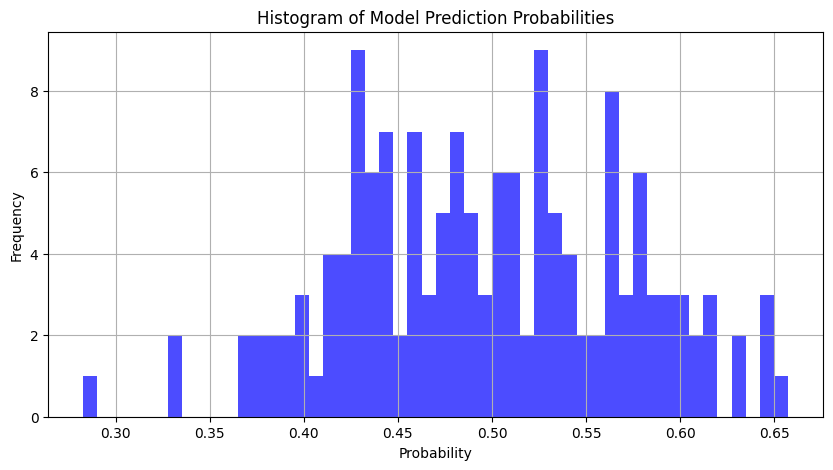

In [15]:
# Cell 8: Visualize Histogram of Probabilities
# Plot a histogram to see the distribution of the probability vector.

plt.figure(figsize=(10, 5))
plt.hist(probs, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Model Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [98]:
# Cell 9: Apply Mapping and Max Pooling → Display as Table

import pandas as pd
import numpy as np

# Get only the mapped target labels
mapped_labels = [label for label in target_labels if label in mapper]

# Compute max-pooled probability for each mapped label
mapped_probs = np.zeros(len(mapped_labels))

for j, label in enumerate(mapped_labels):
    source_indices = mapper[label]
    if len(source_indices) > 0:
        mapped_probs[j] = np.max(probs[source_indices])

# Get corresponding ground truth (make sure it's numpy)
gt_mapped_np = gt_labels.cpu().numpy() if torch.is_tensor(gt_labels) else np.asarray(gt_labels)

# Find indices in the original target order
mapped_target_indices = [target_labels.index(label) for label in mapped_labels]
gt_mapped = gt_mapped_np[mapped_target_indices]

# ────────────────────────────────────────────────
# Create a clean comparison table
# ────────────────────────────────────────────────

df_mapped = pd.DataFrame({
    'Target Label': mapped_labels,
    'Mapped Probability': np.round(mapped_probs, 4),
    'Ground Truth': gt_mapped.astype(int),          # ensure 0/1 display
    'Predicted Positive (>0.5)': mapped_probs > 0.5
})

# Sort by probability descending (most confident first)
df_mapped = df_mapped.sort_values('Mapped Probability', ascending=False).reset_index(drop=True)

# Optional: add rank column
df_mapped.insert(0, 'Rank', range(1, len(df_mapped) + 1))

# Nice styling for Jupyter
def style_positive(row):
    if row['Mapped Probability'] > 0.5:
        return ['background-color: #fffff'] * len(row)  # light green
    return [''] * len(row)

styled = df_mapped.style.apply(style_positive, axis=1)

print(f"Sample index: {sample_idx}   |   Mapped labels: {len(mapped_labels)}")
print("Mapped Predictions vs Ground Truth (sorted by probability):")
display(styled)

# Quick summary line
n_positive = (mapped_probs > 0.5).sum()
print(f"→ {n_positive} out of {len(mapped_probs)} labels predicted positive (threshold 0.5)")

Sample index: 0   |   Mapped labels: 17
Mapped Predictions vs Ground Truth (sorted by probability):


,Rank,Target Label,Mapped Probability,Ground Truth,Predicted Positive (>0.5)
0,1,right axis deviation,0.629200,0,True
1,2,sinus tachycardia,0.605800,0,True
2,3,atrial fibrillation,0.581100,1,True
3,4,left axis deviation,0.577200,1,True
4,5,t wave inversion,0.576200,0,True
5,6,premature atrial contraction,0.569400,0,True
6,7,t wave abnormal,0.563700,1,True
7,8,low qrs voltages,0.558900,0,True
8,9,sinus arrhythmia,0.552600,0,True
9,10,right bundle branch block,0.549800,0,True


→ 16 out of 17 labels predicted positive (threshold 0.5)


In [94]:
# Cell: Combined Top Predictions Table (fixed tensor → numpy conversion)

import pandas as pd
import numpy as np

# ────────────────────────────────────────────────
# Convert ground truth to NumPy **once**, early
# ────────────────────────────────────────────────
gt_mapped_np = gt_mapped.cpu().numpy() if torch.is_tensor(gt_mapped) else gt_mapped

# ────────────────────────────────────────────────
# Get top 10 mapped predictions (highest prob first)
# ────────────────────────────────────────────────

# Safe descending sort (avoids stride issues)
sorted_idx = np.argsort(mapped_probs)[::-1].copy()   # .copy() prevents negative stride problems
top10_idx = sorted_idx[:10]

top10_labels   = [mapped_labels[i] for i in top10_idx]
top10_probs    = mapped_probs[top10_idx].round(4)
top10_gt       = gt_mapped_np[top10_idx]             # now using numpy version

# ────────────────────────────────────────────────
# Contributing source labels
# ────────────────────────────────────────────────

top10_sources = []
for i in top10_idx:
    label = mapped_labels[i]
    source_indices = mapper.get(label, [])
    source_names = [ecgfounder_labels[idx] for idx in source_indices]
    if len(source_names) > 3:
        sources_str = ", ".join(source_names[:3]) + f" +{len(source_names)-3} more"
    else:
        sources_str = ", ".join(source_names) if source_names else "—"
    top10_sources.append(sources_str)

# ────────────────────────────────────────────────
# Build comparison table
# ────────────────────────────────────────────────

df_comparison = pd.DataFrame({
    'Rank': range(1, len(top10_labels)+1),
    'Target Label': top10_labels,
    'Probability': top10_probs,
    'Ground Truth': top10_gt.astype(int),           # now safe — it's numpy
    'Contributing ECGFounder Labels (max pooled)': top10_sources
})

# Optional: nice highlighting in Jupyter
def highlight_positive(row):
    color = ''
    if row['Probability'] > 0.5:
        color = 'background-color: #fffff'  # light green
    elif row['Probability'] > 0.3:
        color = 'background-color: #fffff'  # light yellow
    return [color] * len(row)

styled_df = df_comparison.style.apply(highlight_positive, axis=1)

print(f"Top 10 Mapped Predictions — Sample index: {sample_idx}")
print(f"Total mapped labels: {len(mapped_labels)}")
display(styled_df)

# Summary
n_pred_pos = (mapped_probs > 0.5).sum()
print(f"\nMapped predictions > 0.5: {n_pred_pos} / {len(mapped_probs)}")
if n_pred_pos > 0:
    print(f"True positives among top 10: {(top10_gt > 0).sum()}")

Top 10 Mapped Predictions — Sample index: 0
Total mapped labels: 17


,Rank,Target Label,Probability,Ground Truth,Contributing ECGFounder Labels (max pooled)
0,1,right axis deviation,0.629200,0,"RIGHT AXIS DEVIATION, RIGHTWARD AXIS, RIGHT SUPERIOR AXIS DEVIATION +1 more"
1,2,sinus tachycardia,0.605800,0,SINUS TACHYCARDIA
2,3,atrial fibrillation,0.581100,1,"ATRIAL FIBRILLATION, WITH RAPID VENTRICULAR RESPONSE, WITH SLOW VENTRICULAR RESPONSE"
3,4,left axis deviation,0.577200,1,"LEFT AXIS DEVIATION, LEFTWARD AXIS, ABNORMAL LEFT AXIS DEVIATION"
4,5,t wave inversion,0.576200,0,"NONSPECIFIC T WAVE ABNORMALITY, T WAVE INVERSION NOW EVIDENT IN, INVERTED T WAVES HAVE REPLACED NONSPECIFIC T WAVE ABNORMALITY IN +1 more"
5,6,premature atrial contraction,0.569400,0,"PREMATURE ATRIAL COMPLEXES, PREMATURE SUPRAVENTRICULAR COMPLEXES, PREMATURE ECTOPIC COMPLEXES +1 more"
6,7,t wave abnormal,0.563700,1,"NONSPECIFIC T WAVE ABNORMALITY, NONSPECIFIC T WAVE ABNORMALITY NOW EVIDENT IN, NONSPECIFIC ST AND T WAVE ABNORMALITY +2 more"
7,8,low qrs voltages,0.558900,0,LOW VOLTAGE QRS
8,9,sinus arrhythmia,0.552600,0,"WITH SINUS ARRHYTHMIA, WITH MARKED SINUS ARRHYTHMIA"
9,10,right bundle branch block,0.549800,0,"RIGHT BUNDLE BRANCH BLOCK, INCOMPLETE RIGHT BUNDLE BRANCH BLOCK, LEFT ANTERIOR FASCICULAR BLOCK +3 more"



Mapped predictions > 0.5: 16 / 17
True positives among top 10: 3


## strict mapping

In [1]:
"""
=================================================================================
ZERO-SHOT EVALUATION: FLEXIBLE MAPPING (MANY-TO-ONE or STRICT 1-TO-1)
=================================================================================

Supported modes:
- "many_to_one"     : multiple source labels → max pooling (original)
- "strict_one_to_one": exactly one source label per target → direct copy (no pooling)

Choose via mapping_mode parameter in run_evaluation()
=================================================================================
"""

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# LABEL LOADING (unchanged)
# =============================================================================

def load_ecgfounder_labels(tasks_txt_path):
    with open(tasks_txt_path, 'r') as f:
        labels = [line.strip() for line in f.readlines() if line.strip()]
    print(f"✓ Loaded {len(labels)} ECGFounder labels from tasks.txt")
    return labels


def load_target_labels_from_data(test_df, dx_csv_path):
    dx_df = pd.read_csv(dx_csv_path)
    dx_df["SNOMEDCTCode"] = dx_df["SNOMEDCTCode"].astype(str)
    snomed_to_dx = dict(zip(dx_df["SNOMEDCTCode"], dx_df["Dx"]))
    non_label_cols = {"path", "age", "gender", "fs"}
    label_codes = [col for col in test_df.columns if col not in non_label_cols]
    target_labels = [snomed_to_dx.get(code, f"Unknown_{code}") for code in label_codes]
    print(f"✓ Loaded {len(target_labels)} target labels from test DataFrame")
    print(f"  Label codes (SNOMED): {label_codes}")
    return target_labels, label_codes, snomed_to_dx


# =============================================================================
# FLEXIBLE MAPPER (supports both many-to-one and strict 1-to-1)
# =============================================================================

def build_mapper(target_labels, ecgfounder_labels, mode="many_to_one"):
    """
    Build label mapper.
    
    mode:
      - "many_to_one"       → allow multiple sources per target (use max pooling)
      - "strict_one_to_one" → enforce exactly ONE source per target (best match only)
    """
    if mode not in ["many_to_one", "strict_one_to_one"]:
        raise ValueError("mode must be 'many_to_one' or 'strict_one_to_one'")

    ecgfounder_lower = {label.lower(): i for i, label in enumerate(ecgfounder_labels)}
    
    print("\n" + "="*100)
    print(f"BUILDING MAPPER ({mode.upper().replace('_', ' ')})")
    print("="*100)
    
    mapping_rules = {
        "1st degree av block": ["with 1st degree av block", "with prolonged av conduction"],
        "atrial fibrillation": ["atrial fibrillation", "with rapid ventricular response", "with slow ventricular response"],
        "atrial flutter": ["atrial flutter", "with 2:1 av conduction"],
        "incomplete right bundle branch block": ["incomplete right bundle branch block", "rsr' or qr pattern in v1 suggests right ventricular conduction delay", "rsr' pattern in v1"],
        "left anterior fascicular block": ["left anterior fascicular block"],
        "left axis deviation": ["left axis deviation", "leftward axis", "abnormal left axis deviation"],
        "left bundle branch block": ["left bundle branch block", "with qrs widening"],
        "low qrs voltages": ["low voltage qrs"],
        "premature atrial contraction": ["premature atrial", "premature supraventricular complexes", "premature ectopic complexes"],
        "right axis deviation": ["right axis deviation", "rightward axis", "abnormal right axis deviation", "right superior axis deviation"],
        "right bundle branch block": ["right bundle branch block", "rbbb and left anterior fascicular block", "rbbb and left posterior fascicular block"],
        "sinus arrhythmia": ["with sinus arrhythmia", "with marked sinus arrhythmia"],
        "sinus bradycardia": ["sinus bradycardia", "marked sinus bradycardia"],
        "sinus rhythm": ["sinus rhythm", "normal sinus rhythm"],
        "sinus tachycardia": ["sinus tachycardia"],
        "t wave abnormal": ["nonspecific t wave abnormality", "nonspecific st and t wave abnormality", "t wave abnormality", "nonspecific t wave abnormality now evident in"],
        "t wave inversion": ["t wave inversion now evident in", "t wave inversion more evident in", "inverted t waves have replaced nonspecific t wave abnormality in"],
    }
    
    mapper = {}
    unmapped = []
    
    for target in target_labels:
        target_lower = target.lower()
        if target_lower not in mapping_rules:
            unmapped.append(target)
            print(f"✗ {target:<45} → NO MAPPING RULE")
            continue
            
        search_terms = mapping_rules[target_lower]
        candidates = []
        
        for search_term in search_terms:
            for ecg_label_lower, idx in ecgfounder_lower.items():
                if search_term in ecg_label_lower or ecg_label_lower in search_term:
                    if any(x in ecg_label_lower for x in ["no longer", "less evident", "more evident"]):
                        continue
                    candidates.append((len(ecg_label_lower), idx, ecgfounder_labels[idx], search_term))
        
        if not candidates:
            unmapped.append(target)
            print(f"✗ {target:<45} → NO MATCH FOUND")
            continue
        
        # Sort candidates: shorter label first (more specific), then by search term priority
        candidates.sort()
        
        if mode == "strict_one_to_one":
            # Take ONLY the best (shortest) match
            best_len, best_idx, best_label, used_term = candidates[0]
            mapper[target] = [best_idx]
            print(f"✓ {target:<45} → [{best_idx:>3}] {best_label} (from '{used_term}')")
        else:
            # many_to_one: collect all unique
            indices = set()
            for _, idx, label, term in candidates:
                indices.add(idx)
                print(f"✓ {target:<45} → [{idx:>3}] {label} (from '{term}')")
            mapper[target] = sorted(list(indices))
    
    print(f"\n  Mapped: {len(mapper)} / {len(target_labels)}")
    if unmapped:
        print(f"  Unmapped: {unmapped}")
    
    return mapper


def print_mapper_table(target_labels, mapper, ecgfounder_labels, mode="many_to_one"):
    title = "MANY-TO-ONE" if mode == "many_to_one" else "STRICT 1-TO-1"
    print("\n" + "="*100)
    print(f"{title} LABEL MAPPING (FINAL)")
    print("="*100)
    print(f"\n{'Target Label':<45} | {'Source Labels'}")
    print("-"*100)
    
    mapped_count = 0
    for target in target_labels:
        indices = mapper.get(target, [])
        if indices:
            sources = [ecgfounder_labels[i] for i in indices]
            print(f"✓ {target:<43} | {', '.join(sources)}")
            mapped_count += 1
        else:
            print(f"✗ {target:<43} | UNMAPPED")
    
    print("-"*100)
    print(f"Summary: {mapped_count}/{len(target_labels)} targets mapped")
    print()


# =============================================================================
# EVALUATION (adaptive to mapping mode)
# =============================================================================

def evaluate_zero_shot(model, loader, target_labels, mapper, ecgfounder_labels, device, 
                       mapping_mode="many_to_one", split_name="test"):
    
    model.eval()
    all_gt = []
    all_pred_ecg = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", leave=False):
            if isinstance(batch, (tuple, list)):
                x, y = batch[0], batch[1]
            else:
                x = batch.get('x') or batch.get('ECG')
                y = batch.get('y') or batch.get('labels')
            
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            all_gt.append(y.cpu())
            all_pred_ecg.append(probs.cpu())
    
    all_gt = torch.cat(all_gt, dim=0).numpy()
    all_pred_ecg = torch.cat(all_pred_ecg, dim=0).numpy()
    
    mapped_labels = [label for label in target_labels if label in mapper]
    mapped_target_indices = [i for i, label in enumerate(target_labels) if label in mapper]
    all_gt_mapped = all_gt[:, mapped_target_indices]
    
    N = all_pred_ecg.shape[0]
    pred = np.zeros((N, len(mapped_labels)))
    
    for j, label in enumerate(mapped_labels):
        source_indices = mapper[label]
        if len(source_indices) == 0:
            continue
        if mapping_mode == "many_to_one" and len(source_indices) > 1:
            pred[:, j] = np.max(all_pred_ecg[:, source_indices], axis=1)
        else:
            # strict 1:1 or single source → direct copy
            pred[:, j] = all_pred_ecg[:, source_indices[0]]
    
    # ────────────────────────────────────────────────
    # Metrics calculation (unchanged from your version)
    # ────────────────────────────────────────────────
    
    results = []
    for j, label in enumerate(mapped_labels):
        y_true = all_gt_mapped[:, j]
        y_pred = pred[:, j]
        n_pos = int(y_true.sum())
        n_neg = len(y_true) - n_pos
        
        if n_pos > 0 and n_neg > 0 and y_pred.max() > y_pred.min():
            try:
                auroc = roc_auc_score(y_true, y_pred)
                auprc = average_precision_score(y_true, y_pred)
            except:
                auroc = auprc = np.nan
        else:
            auroc = auprc = np.nan
        
        results.append({
            'label': label, 'n_pos': n_pos, 'n_neg': n_neg,
            'auroc': auroc, 'auprc': auprc,
            'pred_mean': y_pred.mean(), 'pred_std': y_pred.std(),
            'pred_min': y_pred.min(), 'pred_max': y_pred.max()
        })
    
    valid_results = [r for r in results if not np.isnan(r['auroc'])]
    
    if valid_results:
        valid_indices = [i for i, r in enumerate(results) if not np.isnan(r['auroc'])]
        y_true_v = all_gt_mapped[:, valid_indices]
        y_pred_v = pred[:, valid_indices]
        macro_auroc = roc_auc_score(y_true_v, y_pred_v, average='macro')
        micro_auroc = roc_auc_score(y_true_v, y_pred_v, average='micro')
        macro_auprc = average_precision_score(y_true_v, y_pred_v, average='macro')
        micro_auprc = average_precision_score(y_true_v, y_pred_v, average='micro')
    else:
        macro_auroc = micro_auroc = macro_auprc = micro_auprc = np.nan
    
    near_half = ((pred > 0.45) & (pred < 0.55)).sum()
    near_half_pct = 100 * near_half / pred.size if pred.size > 0 else 0
    
    return {
        'per_class': results,
        'macro_auroc': macro_auroc, 'micro_auroc': micro_auroc,
        'macro_auprc': macro_auprc, 'micro_auprc': micro_auprc,
        'mapped_labels': mapped_labels,
        'pred_mean': pred.mean(), 'near_half_pct': near_half_pct,
        'n_samples': N, 'n_valid_classes': len(valid_results)
    }


# =============================================================================
# MAIN EVALUATION FUNCTION (choose mode here)
# =============================================================================

def run_evaluation(
    model, train_loader, test_loader, target_labels, ecgfounder_labels,
    mapping_mode="many_to_one", device=None
):
    mapper = build_mapper(target_labels, ecgfounder_labels, mode=mapping_mode)
    print_mapper_table(target_labels, mapper, ecgfounder_labels, mode=mapping_mode)
    
    print("="*100)
    print(f"ZERO-SHOT EVALUATION: {mapping_mode.upper().replace('_', ' ')}")
    print("="*100)
    
    results = {}
    for split_name, loader in [ ("TEST", test_loader)]:
        print(f"\n{split_name} SET:")
        print("-"*80)
        res = evaluate_zero_shot(
            model, loader, target_labels, mapper, ecgfounder_labels,
            device, mapping_mode=mapping_mode, split_name=split_name.lower()
        )
        results[split_name.lower()] = res
        
        print(f"  Samples: {res['n_samples']}")
        print(f"  Mapped labels: {len(res['mapped_labels'])} / {len(target_labels)}")
        print(f"  Valid classes: {res['n_valid_classes']}")
        print(f"  Macro AUROC: {res['macro_auroc']:.4f}")
        print(f"  Micro AUROC: {res['micro_auroc']:.4f}")
        print(f"  Macro AUPRC: {res['macro_auprc']:.4f}")
        print(f"  Micro AUPRC: {res['micro_auprc']:.4f}")
        print(f"  Mean pred:   {res['pred_mean']:.4f}")
        print(f"  Near 0.5:    {res['near_half_pct']:.1f}%")
    
    # Per-class table, summary, etc. (same as before)
    # ... (you can copy-paste your original per-class printing / summary code here)
    
    return results


# =============================================================================
# STANDALONE EXECUTION
# =============================================================================

if __name__ == "__main__":
    # ────────────────────────────────────────────────
    # CONFIG
    # ────────────────────────────────────────────────
    TASKS_TXT_PATH = "/home/zoorab/projects/ECGFounder/tasks.txt"
    DX_CSV_PATH    = "/home/zoorab/projects/12-lead-ecg-classifier/data/scored_diagnoses_2021.csv"
    MODEL_PTH      = "/home/zoorab/projects/ECGFounder/12_lead_ECGFounder.pth"
    TRAIN_CSV      = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/clean_cpsc_sph_chapman_ptb_v2.csv"
    TEST_CSV       = "/home/zoorab/projects/12-lead-ecg-classifier/data/split_csvs/G12EC/clean_all_g12ec.csv"
    
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    
    # Choose mode here ──────────────── CHANGE THIS LINE TO SWITCH MODE
    MAPPING_MODE = "strict_one_to_one"          # or "strict_one_to_one"
    # ────────────────────────────────────
    
    print("\n" + "="*100)
    print("STARTING ZERO-SHOT EVALUATION")
    print(f"Mapping mode: {MAPPING_MODE.upper()}")
    print("="*100)
    
    ecgfounder_labels = load_ecgfounder_labels(TASKS_TXT_PATH)
    test_df = pd.read_csv(TEST_CSV)
    target_labels, label_codes, snomed_to_dx = load_target_labels_from_data(test_df, DX_CSV_PATH)
    
    # Load model (same as before)
    from finetune_model import ft_12lead_ECGFounder
    model = ft_12lead_ECGFounder(
        device=device, pth=MODEL_PTH,
        n_classes=len(ecgfounder_labels), linear_prob=False
    ).to(device)
    model.eval()
    
    # Load datasets
    from dataset import LVEF_12lead_cls_Dataset
    train_df = pd.read_csv(TRAIN_CSV)
    train_dataset = LVEF_12lead_cls_Dataset('', train_df)
    test_dataset  = LVEF_12lead_cls_Dataset('', test_df)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4)
    
    # Run evaluation with chosen mode
    results = run_evaluation(
        model, train_loader, test_loader,
        target_labels, ecgfounder_labels,
        mapping_mode=MAPPING_MODE,
        device=device
    )
    
    print("="*100)
    print("DONE!")
    print("="*100)


STARTING ZERO-SHOT EVALUATION
Mapping mode: STRICT_ONE_TO_ONE
✓ Loaded 150 ECGFounder labels from tasks.txt
✓ Loaded 17 target labels from test DataFrame
  Label codes (SNOMED): ['426783006', '426177001', '164934002', '427393009', '713426002', '427084000', '59118001', '164889003', '59931005', '47665007', '445118002', '39732003', '164890007', '164909002', '270492004', '251146004', '284470004']

BUILDING MAPPER (STRICT ONE TO ONE)
✓ sinus rhythm                                  → [  3] SINUS RHYTHM (from 'normal sinus rhythm')
✓ sinus bradycardia                             → [  4] SINUS BRADYCARDIA (from 'marked sinus bradycardia')
✓ t wave abnormal                               → [ 14] NONSPECIFIC T WAVE ABNORMALITY (from 'nonspecific t wave abnormality')
✓ sinus arrhythmia                              → [ 34] WITH SINUS ARRHYTHMIA (from 'with sinus arrhythmia')
✓ incomplete right bundle branch block          → [ 96] RSR' PATTERN IN V1 (from 'rsr' pattern in v1')
✓ sinus tachycardia  

test:   0%|          | 0/69 [00:00<?, ?it/s]

  Samples: 8827
  Mapped labels: 17 / 17
  Valid classes: 17
  Macro AUROC: 0.4692
  Micro AUROC: 0.4980
  Macro AUPRC: 0.0974
  Micro AUPRC: 0.0897
  Mean pred:   0.5150
  Near 0.5:    46.8%
DONE!


The following table shows the **Macro AUC scores on the G12EC dataset**:

| **Method** | **Macro AUC** |
| --- | --- |
| Zero-Shot (Direct Manual Mapping) | 0.5858 |
| Feature + Linear Probe | 0.9081 |
| Training Teacher from Scratch | 0.9106 |
| Training Teacher with Full Fine-Tuning | **0.9252** |

The table results showing that the Zero-Shot not working and fine-tuning the foundation model, was better than training it from scratch on the CinC21 data

--------------------